In [1]:
import numpy as np
from matplotlib import pyplot as plt
from SYK_fft import *
from ConformalAnalytical import *
import testingscripts
from scipy.signal import find_peaks

In [2]:
testingscripts.realtimeFFT_validator() # Should return True

True

In [3]:
def rhotosigma(rhoG,rhoD,M,dt,t,g,beta,kappa=1,delta=1e-6):
    '''
    returns [Sigma,Pi] given rhos
    '''
    eta = np.pi/(M*dt)*(0.001)
    rhoGrev = np.concatenate(([rhoG[-1]], rhoG[1:][::-1]))
    rhoFpp = (1/np.pi)*freq2time(rhoG * fermidirac(beta*omega),M,dt)
    rhoFpm = (1/np.pi)*freq2time(rhoG * fermidirac(-1.*beta*omega),M,dt)
    rhoFmp = (1/np.pi)*freq2time(rhoGrev * fermidirac(beta*(omega)),M,dt)
    rhoFmm = (1/np.pi)*freq2time(rhoGrev * fermidirac(-1.*beta*omega),M,dt)
    rhoBpp = (1/np.pi)*freq2time(rhoD * boseeinstein(beta*(omega+eta)),M,dt)
    rhoBpm = (1/np.pi)*freq2time(rhoD * boseeinstein(-1.*beta*(omega+eta)),M,dt)
    
    argSigma = (rhoFpm*rhoBpm - rhoFpp*rhoBpp) * np.exp(-np.abs(delta*t)) * np.heaviside(t,1)
    #argSigma = (rhoFpm*rhoBpm - rhoFpp*rhoBpp) * np.heaviside(t,1)
    Sigma = 1j*(g**2)*kappa * time2freq(argSigma,M,dt)
    
    argPi = (rhoFpp*rhoFmp - rhoFpm*rhoFmm) * np.exp(-np.abs(delta*t)) * np.heaviside(t,1)
    #argPi = (rhoFpp*rhoFmp - rhoFpm*rhoFmm) * np.heaviside(t,1)
    Pi = 2*1j*(g**2) * time2freq(argPi,M,dt)
    
    return [Sigma, Pi]

In [4]:
g = 0.5
mu = 0.
#r = 0.001
#r = 0. 
#r = 1.
r = 1.

beta = 50.

M = int(2**20) #number of points in the grid
T = 2**12 #upper cut-off for the time
dt = (2*T)/((2*M))
t = dt * (np.arange(2*M) - M)

dw = np.pi/(M*dt)
#eta = 1.1011011101111011111 * dw * 0.1
#eta = dw*2.1
#eta = dw*1.000001
#eta = dw*0.01
#eta = dw*2.
eta = dw*11.

omega = dw * (np.arange(2*M) - M) 
np.testing.assert_almost_equal(dt*dw*M,np.pi,5, "Error in fundamentals")
err = 1e-1
print("omega max = ", omega[-1], "dw = ", dw )
print("dt = ", dt)
Tstar = g**2 * np.sqrt(r)

delta = 0.420374134464041
np.testing.assert_almost_equal(np.max(np.abs(omega)),np.pi*M/T,5,"Error in creating omega grid")
print('r = ', r, ' ,temp/dw = ', 1./(beta*dw))
print('Temp = ', 1/beta, ' Tstar = ', Tstar)

omega max =  804.2469523285931 dw =  0.0007669903939428206
dt =  0.00390625
r =  1.0  ,temp/dw =  26.07594587617613
Temp =  0.02  Tstar =  0.25


In [5]:
#GRomega = (-1j)*np.ones(2*M)
#GRomega = time2freq((-1j)*np.ones(2*M)*np.heaviside(t,1.0),M,dt)
#GRomega = time2freq(GRconf(t+1j*delta,J = Jot,beta = beta),M,dt)
# GRomega = 1/(omega + 1j*eta + mu)
# DRomega = 1/(-1.0*(omega + 1j*eta)**2 + r)
#DRomega = -1.0*np.ones(2*M)
#DRomega = time2freq(-1.0*np.ones(2*M)*np.heaviside(t,1.0),M,dt)
# DRomega = DconfImag(-1j*(omega),g,beta)
# GRomega = GconfImag(-1j*(omega+1j*eta),g,beta)
DRomega = CrazyDconfReal(omega,g,beta,eta)
GRomega = CrazyGconfReal(omega,g,beta,eta)

# GRt = (0.5/np.pi) * freq2time(GRomega - GfreeRealomega(omega,mu,eta),M,dt) + GfreeRealt(t,mu,eta)
# DRt = (0.5/np.pi) * freq2time(DRomega - DfreeRealomega(omega,r,eta),M,dt) + DfreeRealt(t,r,eta)
# GRt[:M] = 0
# DRt[:M] = 0
# GRomega = time2freq(GRt,M,dt)
# DRomega = time2freq(DRt,M,dt)



itern = 0

omegar2 = ret_omegar2(g,beta)

diff = 1 
diffG,diffD = (0.5,0.5)
xG,xD = (0.5,0.5)


while (diff>err and itern<150): 
    itern += 1 
    diffoldG,diffoldD = (diffG,diffD)
    GRoldomega,DRoldomega = (1.0*GRomega, 1.0*DRomega)
    
    rhoG = -1.0*np.imag(GRomega)
    rhoD = -1.0*np.imag(DRomega)
    
    SigmaOmega,PiOmega = rhotosigma(rhoG,rhoD,M,dt,t,g,beta,kappa=1,delta=eta)
    #PiOmega[M] = 1.0*r - omegar2 + eta**2
    PiOmega[M] = -1.0*r - omegar2 - eta**2
    
    # if itern < 20 : 
    #     PiOmega[M] = 1.0*r - omegar2 + eta**2
   
    GRomega = 1.0*xG/(omega + 1j*eta + mu - SigmaOmega) + (1-xG)*GRoldomega
    #DRomega = 1.0*xD/(-1.0*(omega+1j*eta)**2 + r - PiOmega) + (1-xD)*DRoldomega
    DRomega = 1.0*xD/(1.0*(omega+1j*eta)**2 - r - PiOmega) + (1-xD)*DRoldomega
    
#     GRt = (0.5/np.pi) * freq2time(GRomega,M,dt)
#     DRt = (0.5/np.pi) * freq2time(DRomega,M,dt)
#     #GRt = GRt - np.real(GRt) # make G(t) purely imaginary 
#     #DRt = DRt - np.imag(DRt) # make D(t) purely real
#     #GRt[:M] = 0
#     #DRt[:M] = 0
#     GRt[M] = -1j
#     DRt[M] = 0
    
#     if itern > 10 :
#         #GRt = GRt - np.real(GRt) # make G(t) purely imaginary 
#         #DRt = DRt - np.imag(DRt) # make D(t) purely real
#         #GRt[:M] = 0
#         #DRt[:M] = 0
#         #GRt[M] = -1j
#         #DRt[M] = 0
#         eta=dw*0.01
    
    
#     GRomega = time2freq(GRt,M,dt)
#     DRomega = time2freq(DRt,M,dt)
    

   
    #diffG = np. sqrt((0.5/M) * np.sum((np.abs(GRomega-GRoldomega))**2)) #changed
    #diffD = np. sqrt((0.5/M) * np.sum((np.abs(DRomega-DRoldomega))**2))
    diffG = np. sqrt(np.sum((np.abs(GRomega-GRoldomega))**2)) #changed
    diffD = np. sqrt(np.sum((np.abs(DRomega-DRoldomega))**2))
    #diff = np.max([diffG,diffD])
    diff = 0.5*(diffG+diffD)
    diffG,diffD = diff,diff
    
    if diffG>diffoldG:
        xG/=2.
    if diffD>diffoldD:
        xD/=2.
    
    
    print("itern = ",itern, " , diff = ", diffG, diffD, " , x = ", xG, xD, end = '\r')
        



boo
bar


/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK/SYK_fft.py:87: RuntimeWarning: overflow encountered in exp
  return (1.0/(1.0 + np.exp(arg)))
/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK/SYK_fft.py:102: RuntimeWarning: overflow encountered in exp
  return (1.0/(np.exp(arg)-1))


In [6]:
#GRt = (0.5/np.pi) * freq2time(GRomega,M,dt)
#DRt = (0.5/np.pi) * freq2time(DRomega,M,dt)

GRt = (0.5/np.pi) * freq2time(GRomega - GfreeRealomega(omega,mu,eta),M,dt) + GfreeRealt(t,mu,eta)
DRt = (0.5/np.pi) * freq2time(DRomega - DfreeRealomega(omega,r,eta),M,dt) + DfreeRealt(t,r,eta)

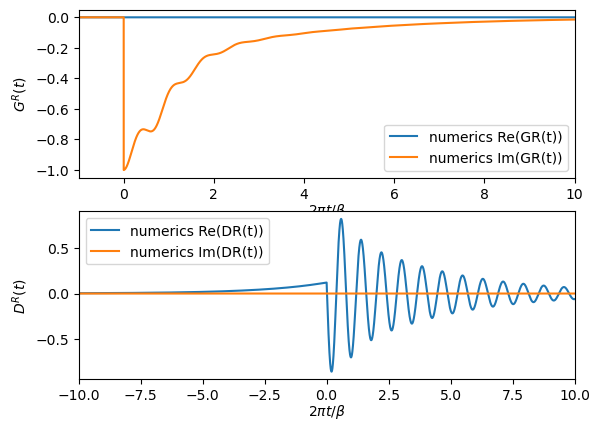

In [7]:
fig, ax = plt.subplots(2)

ax[0].plot(2*np.pi*t/beta, np.real(GRt), label = r'numerics Re(GR(t))')
ax[0].plot(2*np.pi*t/beta, np.imag(GRt), label = r'numerics Im(GR(t))')
#ax[0].plot(tau/beta, np.real(Gconftau), 'b--', label = 'analytical Gtau' )
#ax[0].set_ylim(-1,1)
ax[0].set_xlim(-1,10)
ax[0].set_xlabel(r'$2\pi t/\beta$',labelpad = 0)
ax[0].set_ylabel(r'${G^R(t)}$')
ax[0].legend()

ax[1].plot(2*np.pi*t/beta, np.real(DRt),'-',label = 'numerics Re(DR(t))')
ax[1].plot(2*np.pi*t/beta, np.imag(DRt), label = 'numerics Im(DR(t))')
#ax[1].plot(tau/beta, np.real(Dconftau), 'b--', label = 'analytical Dtau' )
#ax[1].plot(tau/beta, np.real(FreeDtau), 'g-.', label = 'Free D Dtau' )
#ax[1].set_ylim(0,1)
ax[1].set_xlabel(r'$2\pi t/\beta$',labelpad = 0)
ax[1].set_ylabel(r'${D^R(t)}$')
#ax[1].set_xlim(0,beta/(2*np.pi))
ax[1].set_xlim(-10,10)
ax[1].legend()
# 

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(2)
titlestring = r'$\beta$ = ' + str(beta) + r', $\log_2{M}$ = ' + str(np.log2(M)) + r', $g = $' + str(g)
fig.suptitle(titlestring)
thermalfreeboson = DfreeThermalomega(omega,r,beta,g,eta=eta)



match_omega = 0.5
match_point = M + int(np.floor(match_omega/dw))
om_th = np.sqrt(omegar2)
#om_th = 1/beta
#match_coeff = rhoD[match_point]*(np.abs(omega[match_point])**(4*delta-1))
#match_rhoD = match_coeff * np.abs(omega)**(1-4*delta)
match_coeff = rhoD[match_point]*(np.abs(omega[match_point] - om_th + 1j*eta )**(4*delta-1))
match_rhoD = match_coeff * np.abs(omega-om_th)**(1-4*delta)


#peakrhoD = find_peaks(rhoD)
#print(omega[peakrhoD[-1]])

ax[0].plot(omega, rhoG, 'r', label = r'numerics $\rho_G(\omega)$')
#ax[0].plot(tau/beta, np.real(Gconftau), 'b--', label = 'analytical Gtau' )
#ax[0].set_ylim(-1,1)
ax[0].set_xlim(-0.1,0.1)
ax[0].set_xlabel(r'$\omega$',labelpad = 0)
ax[0].set_ylabel(r'$-\Im{G^R(\omega)}$')
ax[0].legend()

ax[1].plot(omega, rhoD, 'r', label = r'numerics $\rho_D(\omega)$')
#ax[1].plot(omega,-np.imag(thermalfreeboson),label = 'free boson with thermal mass')
ax[1].plot(omega,match_rhoD, c = 'k', ls = '--', label = 'heuristic fit of power law')
ax[1].plot(omega, np.imag(DfreeRealomega(omega,r,eta=om_th)), ls = '--', label = 'free boson with bare mass')

ax[1].set_ylim(-0.2,0.5)
ax[1].set_xlabel(r'$\omega$',labelpad = 0)
ax[1].set_ylabel(r'$-\Im{D^R(\omega)}$')
ax[1].set_xlim(-0.02,1.5)
ax[1].legend()
ax[1].plot(omega, np.zeros_like(omega),ls = '--', c = 'gray')
ax[1].axvline([0], ls = '--', c = 'gray')
ax[1].axvline([1/beta], ls = '--', c = 'gray')
ax[1].axvline([eta], ls = '--', c = 'blue')
#ax[1].axvline([Tstar], ls = '--', c = 'green')
ax[1].axvline(om_th, ls = '--', c = 'orange')
#ax[1].axvline([omega[peakrhoD[0][-1]]], ls = '--', c = 'black')
ax[1].text(1/beta+0.002,0.6, r'$T$',rotation=90)
ax[1].text(eta+0.001,0.4, r'$\eta$',rotation=90)
#ax[1].text(Tstar+0.002,0.4, r'$T^{*}$',rotation=90)

#plt.savefig('KoenraadEmails/thermalfreeboson.pdf')
plt.show()


foo barr


/Users/aravindhswaminathan/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


In [ ]:
dw, 1/beta 

In [ ]:
# powD = 1. - 4*Delta
delta = 0.420374134464041
start,stop = M+1, M+1000


#DRomega = CrazyDconfReal(omega,g,beta,eta)
#GRomega = CrazyGconfReal(omega,g,beta,eta)

fitslice = slice(start, start + 6)
functoplot = rhoG
m,c = np.polyfit(np.log(omega[fitslice]), np.log(np.abs(functoplot[fitslice])),1)
print(f'slope of fit = {m:.03f}')
print('2\Delta - 1 = ', 2*delta-1)


fitG_val = -np.imag(GRomega[start])
# conf_fit_G = 1 * np.abs(omega+1j*eta)**(2*delta - 1)
# conf_fit_G = conf_fit_G/conf_fit_G[start] * fitG_val
conf_fit_G = 1 * np.abs(omega+1j*eta)**(2*delta - 1)
conf_fit_G = conf_fit_G/conf_fit_G[start] * fitG_val


# fitG_val = np.abs(GRomega[start])
# conf_fit_G = 1 * np.abs(omega+1j*eta)**(2*delta - 1)
# conf_fit_G = conf_fit_G/conf_fit_G[start] * fitG_val

# fitD_val = -np.imag(DRomega[start])
# conf_fit_D = 1 * np.abs(omega[start:stop]+1j*eta )**(1-4*delta)
# conf_fit_D = conf_fit_D/conf_fit_D[0] * fitD_val


# fitD_val = np.abs(DRomega[start])
# conf_fit_D = 1 * np.abs(omega[start:stop]+1j*eta)**(1-4*delta)
# conf_fit_D = conf_fit_D/conf_fit_D[0] * fitD_val

fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_figwidth(10)
titlestring = r'$\beta$ = ' + str(beta) + r', $\log_2{M}$ = ' + str(np.log2(M)) + r', $g = $' + str(g)
fig.suptitle(titlestring)
fig.tight_layout(pad=2)

ax1.loglog(np.abs(omega[start:stop]+1j*eta), -np.imag(GRomega[start:stop]),'p',label = 'numerics')
#ax1.loglog(np.abs(omega[start:stop]+1j*eta), np.abs(GRomega[start:stop]),'p',label = 'numerics')
ax1.loglog(np.abs(omega[start:stop]+1j*eta), conf_fit_G[start:stop],'k--',label = 'ES power law')
ax1.loglog(np.abs(omega[start:stop]+1j*eta), np.exp(c)*(omega[start:stop])**m, '--', label = 'power law fit')

ax1.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$-\,\Im{G(\omega)}$')
#ax1.set_ylabel(r'$|G(\omega)|$')
#ax1.set_aspect('equal', adjustable='box')
#ax1.axis('square')
ax1.legend(loc = 'lower left')
#ax1.set_xlim(1e-3,1e-1)

ax2.loglog(np.abs(omega[start:stop] - om_th), -np.imag(DRomega[start:stop]),'p',label='numerics')
#ax2.loglog(np.abs(omega[start:stop]+1j*eta), np.abs(DRomega[start:stop]),'p',label='numerics')
#ax2.loglog(np.abs(omega[start:stop]+1j*eta), conf_fit_D,'k--',label = 'ES power law')
ax2.loglog(np.abs(omega[start:stop]-om_th), match_rhoD[start:stop],'k--',label = 'ES power law')

ax2.set_xlabel(r'$\omega$')
ax2.set_ylabel(r'$-\Im{D(\omega)}$',labelpad = None)
#ax2.set_ylabel(r'$|D(\omega)|$',labelpad = None)
#ax2.set_aspect('equal', adjustable='box')
ax2.legend(loc = 'upper right')
ax2.set_xlim(1e-2,1e0)

#plt.savefig('KoenraadEmails/show_scaling_real_freq.pdf')

# See what the free boson real frequency retarded propagator looks like

In [ ]:
fig,ax = plt.subplots(2)

omega0 = np.sqrt(r)
DR_free_omega = 1./(r - (omega+1j*eta)**2)
#DR_free_omega_left = 0.5/omega0 * (1/(omega +1j*eta + omega0 ))
#DR_free_omega_right = 0.5/omega0 * (-1/(omega + 1j*eta - omega0))
#DR_free_omega = DR_free_omega_left + DR_free_omega_right
DR_free_t = (0.5/np.pi)*freq2time(DR_free_omega,M,dt)
#DR_free_t_left = (0.5/np.pi)*freq2time(DR_free_omega_left,M,dt)
#DR_free_t_right = (0.5/np.pi)*freq2time(DR_free_omega_right,M,dt)
#DR_free_t= DR_free_t_left + DR_free_t_right

ax[0].plot(omega,np.real(DR_free_omega), label = r'$\Re{D_0(\omega)}$')
ax[0].plot(omega,np.imag(DR_free_omega), label = r'$\Im{D_0(\omega)}$')
ax[0].set_xlabel(r'$\omega$')
ax[0].set_ylabel(r'$D_0(\omega+i\eta)$')
ax[0].set_xlim(-0.1,0.1)
ax[0].set_ylim(-2,2)
ax[0].legend(loc = 'upper right')

ax[1].plot(t,np.real(DR_free_t), label = r'$\Re D^R_0(t)$')
ax[1].plot(t,np.imag(DR_free_t), label = r'$\Im D^R_0(t)$')
ax[1].set_xlabel('t')
ax[1].set_ylabel(r'$D_0^R(t)$')
ax[1].set_xlim(-10,10)
ax[1].legend(loc = 'lower left')

''' But wait, shouldn't D_R(t) also be proportional to \theta(t)????? : suspicious '''

In [ ]:
fig,ax = plt.subplots(2)

GR_free_omega = 1./(omega+1j*eta - mu)
GR_free_t = (0.5/np.pi)*freq2time(GR_free_omega,M,dt)

#Gforw = GR_free_t[M:]
#Grev = GR_free_t[:M]
#Grec = np.concatenate((-1.0*Grev,Gforw))

ax[0].plot(omega,np.real(GR_free_omega), label = r'$\Re{G_0(\omega)}$')
ax[0].plot(omega,np.imag(GR_free_omega), label = r'$\Im{G_0(\omega)}$')
ax[0].set_xlabel(r'$\omega$')
ax[0].set_ylabel(r'$G_0(\omega+i\eta)$')
ax[0].set_xlim(-0.1,0.1)
ax[0].set_ylim(-1,1)
ax[0].legend(loc = 'upper right')


ax[1].plot(t,np.real(GR_free_t), label = r'$\Re G^R_0(t)$')
ax[1].plot(t,np.imag(GR_free_t), label = r'$\Im G^R_0(t)$')
#ax[1].plot(t,np.real(Grec), label = r'$\Re Grec(t)$')
#ax[1].plot(t,np.imag(Grec), label = r'$\Im Grec(t)$')
ax[1].set_xlabel('t')
ax[1].set_ylabel(r'$G_0^R(t)$')
ax[1].set_xlim(-5,5)
ax[1].legend(loc = 'lower left')

In [ ]:
DRomega[M:M+2]

In [ ]:
 from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [ ]:
plt.plot(omega, np.imag(DfreeRealomega(omega,r)))
plt.plot(omega,np.imag(thermalfreeboson))
plt.xlim(0,1)
plt.ylim(0,1)

In [ ]:
1/np.sqrt(beta), np.log(0.6)